In [1]:
!nvidia-smi

Tue Apr  9 00:11:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
import PIL
import glob, os, shutil, random

2024-04-09 00:11:55.457191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 00:11:55.457308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 00:11:55.617856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [3]:
path = '/kaggle/input/dog-classification-real-fake'
train_path = '/kaggle/input/dog-classification-real-fake/train'
valid_path = '/kaggle/input/dog-classification-real-fake/valid'
test_path = '/kaggle/input/dog-classification-real-fake/test'

In [4]:
img_width, img_height = 224, 224
batch_size = 16
num_classes = 1
last_activation = 'sigmoid'

train_ds = image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    label_mode='binary'
)

valid_ds = image_dataset_from_directory(
    valid_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    label_mode='binary'
)

test_ds = image_dataset_from_directory(
    test_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    label_mode='binary'
)

Found 991 files belonging to 2 classes.
Found 335 files belonging to 2 classes.
Found 321 files belonging to 2 classes.


In [5]:
labels = train_ds.class_names
labels

['fake', 'real']

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
print(AUTOTUNE)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

-1


# ResNet

### Residual block

In [27]:
def residual_block(input_layer, filter, name, num_layers, size_changed=False):
    
    if num_layers < 50:
    
        if size_changed:
            shortcut = layers.Conv2D(filters=filter, kernel_size=(1, 1), strides=2, name=f'shortcut_{name}')(input_layer)
            conv1 = layers.Conv2D(filters=filter, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name=f'conv_{name}_1')(input_layer)
        else:
            shortcut = input_layer
            conv1 = layers.Conv2D(filters=filter, kernel_size=(3, 3), strides=1, padding='same', activation='relu', name=f'conv_{name}_1')(input_layer)

        conv2 = layers.Conv2D(filters=filter, kernel_size=(3, 3), strides=1, padding='same', activation='relu', name=f'conv_{name}_2')(conv1)
        add_layer = layers.Add(name=f'add_{name}')([shortcut, conv2])
        
    else:
        
        if size_changed:
            conv1 = layers.Conv2D(filters=filter, kernel_size=(1, 1), strides=2, padding='same', activation='relu', name=f'conv_{name}_1')(input_layer)
            shortcut = layers.Conv2D(filters=filter*4, kernel_size=(1, 1), strides=2, name=f'shortcut_{name}')(input_layer)
        else:
            conv1 = layers.Conv2D(filters=filter, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name=f'conv_{name}_1')(input_layer)
            shortcut = layers.Conv2D(filters=filter*4, kernel_size=(1, 1), strides=1, name=f'shortcut_{name}')(input_layer)

        conv2 = layers.Conv2D(filters=filter, kernel_size=(3, 3), strides=1, padding='same', activation='relu', name=f'conv_{name}_2')(conv1)
        conv3 = layers.Conv2D(filters=filter*4, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name=f'conv_{name}_3')(conv2)
        
        add_layer = layers.Add(name=f'add_{name}')([shortcut, conv3])

    return add_layer

### ResNet Model

In [28]:
def resnet(num_conv_layer, filters, num_layers):
    
    input_layer = layers.Input(shape = (img_width, img_height, 3), name='input_layer')

    conv_1 = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation='relu', name='conv_1')(input_layer)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same', name='maxpool_1')(conv_1)
    
    for i, (num_conv, num_filter) in enumerate(zip(num_conv_layers, filters)):
        for j in range(num_conv):
            size_changed = True if j == 0 and i != 0 else False
            x = residual_block(x, num_filter, f'{i+2}_{j+1}', num_layers, size_changed=size_changed)

    avgpool = layers.GlobalAveragePooling2D()(x)
    flat_layer = layers.Flatten(name='fc')(avgpool)
    dense_layer = layers.Dense(1000, activation='relu', name='dense')(flat_layer)
    output_layer = layers.Dense(num_classes, activation=last_activation, name='output')(dense_layer)

    resnet_model = models.Model(inputs=input_layer, outputs=output_layer)
    # resnet_model.summary()
    
    return resnet_model

##### 18-layers
```diff
num_layers = 18
num_conv_layers = [2, 2, 2, 2]
filters = [64, 128, 256, 512]
```

##### 34-layers
```diff
num_layers = 34
num_conv_layers = [3, 4, 6, 3]
filters = [64, 128, 256, 512]
```

##### 50-layers
```diff
num_layers = 50
num_conv_layers = [3, 4, 6, 3]
filters = [64, 128, 256, 512]
```

##### 101-layers
```diff
num_layers = 101
num_conv_layers = [3, 4, 23, 3]
filters = [64, 128, 256, 512]
```

##### 152-layers
```diff
num_layers = 152
num_conv_layers = [3, 8, 36, 3]
filters = [64, 128, 256, 512]
```

In [30]:
num_layers = 152 
num_conv_layers = [3, 8, 36, 3]
filters = [64, 128, 256, 512]

resnet(num_conv_layers, filters, num_layers)

<Functional name=functional_3, built=True>

# Model Training

In [31]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs : {mirrored_strategy.num_replicas_in_sync}")

Number of GPUs : 2


In [32]:
losses = "binary_crossentropy"
metrics = ["accuracy"]

In [33]:
if not os.path.exists('/kaggle/working/checkpoint'):
        os.makedirs('/kaggle/working/checkpoint')
    
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'/kaggle/working/checkpoint/resnet{num_layers}.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=0.0
    )
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
]

In [34]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    
    resnet_model = resnet101()

    opt = tf.keras.optimizers.SGD(0.001, weight_decay=0.0001, momentum=0.9)
    resnet_model.compile(loss=losses, optimizer=opt, metrics=metrics)

In [35]:
history = resnet_model.fit(train_ds, batch_size=batch_size, epochs=100,
                           validation_data=valid_ds, callbacks=callbacks)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 89s 414ms/step - accuracy: 1.0841 - loss: 1.3668 - val_accuracy: 0.5833 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 1.1562 - loss: 1.3504 - val_accuracy: 0.5833 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 1.1776 - loss: 1.3328 - val_accuracy: 0.5833 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 1.2352 - loss: 1.3140 - val_accuracy: 0.3988 - val_loss: 0.8066 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 1.1053 - loss: 1.3622 - val_accuracy: 0.4583 - val_loss: 0.7088 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - accuracy: 1.2139 - loss: 1.3201 - val_accuracy: 0.4345 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 364ms/step - accuracy: 1.2253 - l

In [36]:
hist_df = pd.DataFrame(history.history) 

hist_json_file = f'/kaggle/working/history{num_layers}.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

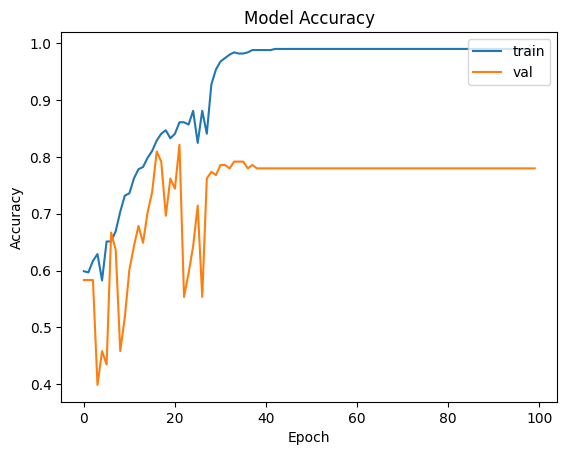

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

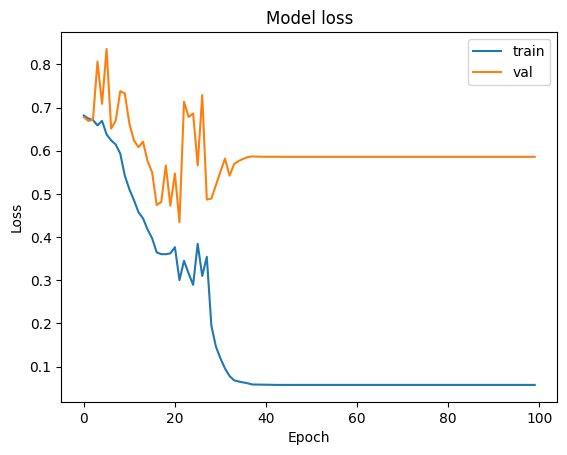

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Prediction

In [22]:
# best_model = models.load_model('/kaggle/working/checkpoint/checkpoint.keras')

In [23]:
# predictions = best_model.predict(test_ds)

In [24]:
# result = best_model.evaluate(test_ds)

In [25]:
'''
plt.figure(figsize=(15, 15))

for x in test_ds:
    pred = prediction_model.predict(x)
    for i in range(batch_size):
        ax = plt.subplot(6, 6, i+1)
        plt.imshow(x[i].numpy().astype("uint8"))
        plt.title(labels[pred.argmax(1)[i]])
        plt.axis("off")
    break
'''

'plt.figure(figsize=(15, 15))\n\nfor x in test_ds:\n    pred = prediction_model.predict(x)\n    for i in range(batch_size):\n        ax = plt.subplot(6, 6, i+1)\n        plt.imshow(x[i].numpy().astype("uint8"))\n        plt.title(labels[pred.argmax(1)[i]])\n        plt.axis("off")\n    break'

In [26]:
'''
import random

plt.figure(figsize=(10, 10))
cnt = 0

for x in test_ds:
    
    i = random.randint(0, 31)
    
    ax = plt.subplot(6, 6, cnt + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(labels[predictions.argmax(1)[(cnt*32)+i]])
    plt.axis("off")
    
    cnt += 1
    if cnt == 36:
        break
'''

'import random\n\nplt.figure(figsize=(10, 10))\ncnt = 0\n\nfor x in test_ds:\n    \n    i = random.randint(0, 31)\n    \n    ax = plt.subplot(6, 6, cnt + 1)\n    plt.imshow(x[i].numpy().astype("uint8"))\n    plt.title(labels[predictions.argmax(1)[(cnt*32)+i]])\n    plt.axis("off")\n    \n    cnt += 1\n    if cnt == 36:\n        break'